# Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# general array and data handling
import numpy as np
import pandas as pd

# tensor operations and neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LeakyReLU, Flatten

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Data Loading

In [3]:
#for use in google colaboratory
#!git clone https://github.com/shusunny/GAN-stock-entry.git

In [4]:
data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[0]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)

GAN-stock-entry/datasets/GOOG.csv


In [5]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,1089.420897,1100.046811,1079.321435,1090.083688,1090.083688,1.671534e+06
std,268.589405,272.693779,265.381490,269.099996,269.099996,7.686312e+05
min,667.849976,672.299988,663.059998,668.260010,668.260010,3.468000e+05
25%,835.755005,841.975006,831.254975,836.994995,836.994995,1.209400e+06
50%,1083.560059,1094.244995,1072.204956,1082.760010,1082.760010,1.466700e+06
75%,1229.390015,1241.369995,1219.445007,1230.540039,1230.540039,1.889050e+06
max,1824.520020,1847.199951,1822.650024,1827.989990,1827.989990,6.348100e+06


In [6]:
dataframe.shape

(1259, 7)

In [7]:
def add_Entry(dataframe):
  for i in range(0,dataframe.shape[0]):
    dataframe.loc[dataframe.index[i],'Entry'] = np.round((dataframe.iloc[i,3]+ (dataframe.iloc[i,2] -dataframe.iloc[i,3])*0.2),5)
  return dataframe

dataframe=add_Entry(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Entry
0,2016-01-04,743.000000,744.059998,731.257996,741.840027,741.840027,3272800,733.81840
1,2016-01-05,746.450012,752.000000,738.640015,742.580017,742.580017,1950700,741.31201
2,2016-01-06,730.000000,747.179993,728.919983,743.619995,743.619995,1947000,732.57198
3,2016-01-07,730.309998,738.500000,719.059998,726.390015,726.390015,2963700,722.94800
4,2016-01-08,731.450012,733.229980,713.000000,714.469971,714.469971,2450900,717.04600


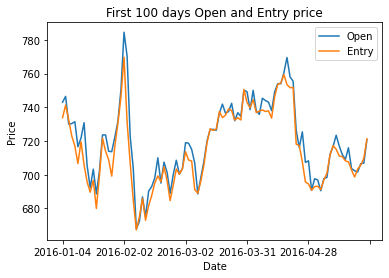

In [8]:
ax = plt.gca()
dataframe.iloc[0:100].plot(x='Date',y='Open',ax=ax)
dataframe.iloc[0:100].plot(x='Date',y='Entry', ax=ax)

plt.title("First 100 days Open and Entry price")
plt.ylabel("Price")
plt.show()

# Preprocessing

In [9]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    std[std==0] = 1
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean[:,6:7])/std[:,6:7] # The entry value is our target
    return samples, targets

In [10]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
targets = np.array([[i**4] for i in range(11)])

print(targets.shape)

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = np.int))
print(y*std[..., 3]+mean[..., 3])

(11, 1)
[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[]


In [11]:
data.shape

(11, 4)

In [12]:
n_sequence = 5
n_batch = 128
n_features = 7

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  targets = data[:,3, None] #add none to have same number of dimensions as data
  #targets = data
  n_samples = data.shape[0]

  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)
  
  return data_gen_train, data_gen_test

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

In [13]:
data_gen_train[0]

(array([[[ 1.81315331e+00,  1.89677802e+00,  1.15129681e+00, ...,
           1.30112422e+00,  1.81173145e+00,  1.38149536e+00],
         [-6.57688733e-01, -7.52972334e-01, -9.75300566e-01, ...,
          -8.43508975e-01,  1.15751418e-01, -9.57634754e-01],
         [-2.66239350e-01, -7.63868799e-01, -8.21767497e-01, ...,
          -1.26815614e+00, -8.86719578e-02, -8.39121916e-01],
         [-1.08245134e+00, -4.89630134e-01, -6.36148363e-01, ...,
          -1.68689524e-01, -8.65761888e-01, -6.24252654e-01],
         [ 1.93226113e-01,  1.09693250e-01,  1.28191961e+00, ...,
           9.79230424e-01, -9.73049022e-01,  1.03951397e+00]],
 
        [[-1.68891637e+00, -1.64234577e+00, -1.56817895e+00, ...,
          -1.47737178e+00, -7.34963560e-01, -1.59004562e+00],
         [-2.60434529e-01, -4.15602305e-01, -3.05800114e-01, ...,
          -1.56874978e-01, -1.14382210e+00, -3.29812456e-01],
         [ 5.03886078e-01,  1.95288809e-01,  2.66132372e-01, ...,
          -5.31495012e-01,  9.35535

In [14]:
# test on data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)

x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5,3] - mean[...,3])/std[...,3]
print(x)
print(y)

assert (x_gen == x).all()
assert (y_gen == y).all()

[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[]
[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[5.69853465]


In [15]:
y_gen.shape

(1, 0)

# Baseline 

In [16]:
# baseline: use previous day as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,3])
baseline_error

3.4528189810500125

In [17]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

C:\Users\shusu\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shusu\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

# Utilities

In [18]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true-y_pred))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:] > y_true[:-1],tf.float32)
    return tf.reduce_mean((y_true[1:]-y_true[:-1])*mask)

 
  
  

# ANN

In [19]:
def make_ANN_model():

  inputs = Input(shape=(n_sequence, n_features,))
  inputs_flatten = Flatten()(inputs)
  ann_1 = Dense(units=1000, activation=None)(inputs_flatten)
  batch_norm1=tf.keras.layers.BatchNormalization()(ann_1)
  ann_1_LRelu = LeakyReLU(alpha=0.3)(ann_1) 
  ann_1_droput = Dropout(0.3)(ann_1_LRelu)
  ann_2 = Dense(units=100, activation=None)(ann_1_droput)
  batch_norm2=tf.keras.layers.BatchNormalization()(ann_2)
  ann_2_LRelu = LeakyReLU(alpha=0.3)(ann_2) 
  ann_2_droput = Dropout(0.3)(ann_2_LRelu)
  output_dense = Dense(1, activation=None)(ann_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 


  model = Model(inputs = inputs, outputs = output)
  #model.compile(loss=generator_loss)
  model.compile(loss='mse', metrics = [mse , mae, mape, rmse, ar])
  #model.compile(loss=None, metrics = [mse , mae, mape, rmse])
  model.summary()

  #return model, slice_model
  return model


# Visualization

In [20]:
metrics = ["loss", 'mse','mae','mape','rmse','ar']
def plot_history(history):
  #metrics = ["loss", 'mse','mae','mape','rmse','ar']
  #metrics = ["gen_loss","gen_slice_loss", 'mse','mae','mape','rmae','ar']
  for metric_name in metrics:  
    plt.figure()
    plt.title(metric_name)
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.plot(history.history[metric_name], label='train')
    plt.plot(history.history["val_"+metric_name], label='test')
    plt.legend()
  plt.show()

#plot_history(history)

In [21]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)
  y_true = target

  plt.figure()
  plt.title("Entry price errors")
  plt.xlabel('Test samples')
  plt.ylabel("Errors")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], lstm)

# Test on all datasets

In [22]:
results = np.zeros((5,6))

### Google Stock

GAN-stock-entry/datasets/GOOG.csv
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 35)                0         
_________________________________________________________________
dense (Dense)                (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_1 (Leaky

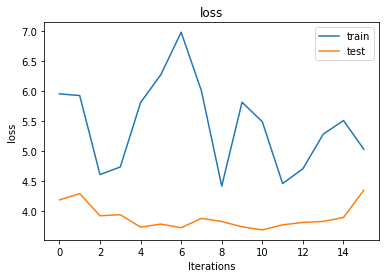

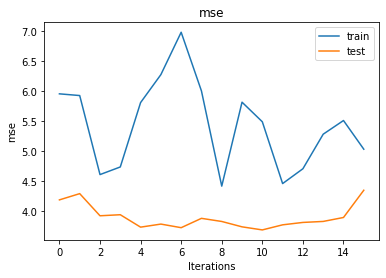

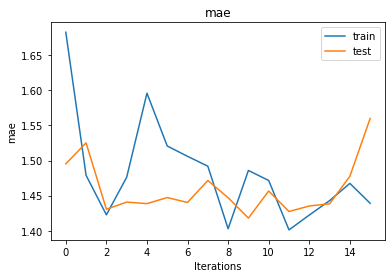

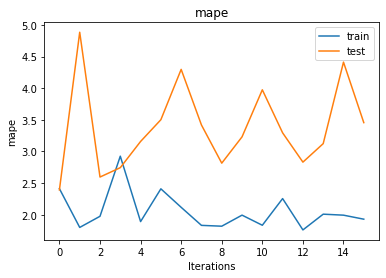

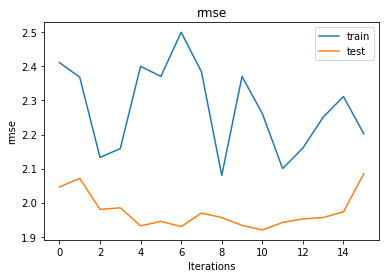

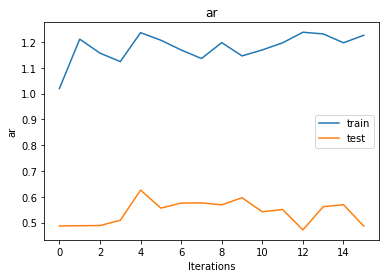

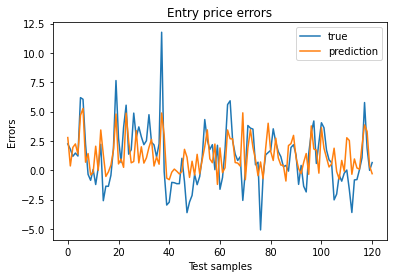

[MSE Baseline] train: 6.395901603878914  test: 5.120497475636998
1/1 [==============================] - 0s 970us/step - loss: 4.3465 - mse: 4.3465 - mae: 1.5600 - mape: 3.4565 - rmse: 2.0848 - ar: 0.4863


In [23]:
data_name = data_names[0]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[0] = ann.evaluate(data_gen_test)

### Apple Stock

GAN-stock-entry/datasets/AAPL.csv
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_4 (Leaky

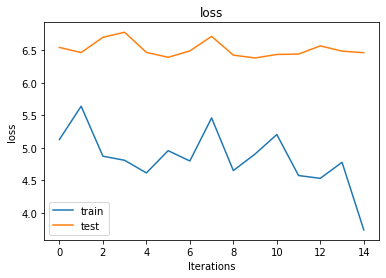

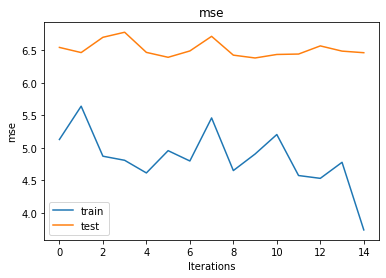

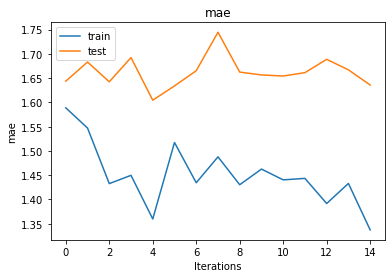

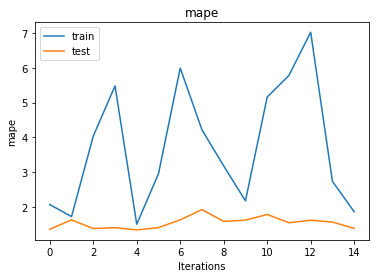

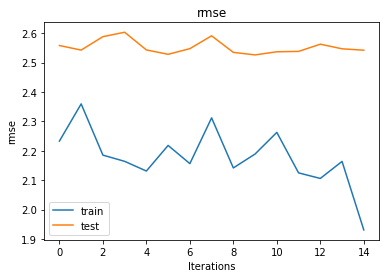

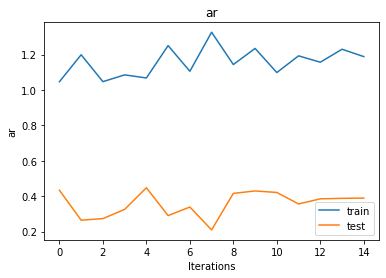

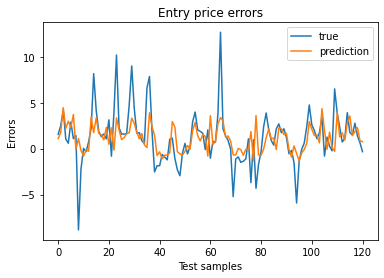

[MSE Baseline] train: 6.804088743791173  test: 7.507943742017371
1/1 [==============================] - 0s 0s/step - loss: 6.4628 - mse: 6.4628 - mae: 1.6359 - mape: 1.3894 - rmse: 2.5422 - ar: 0.3892


In [24]:
data_name = data_names[1]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[1] = ann.evaluate(data_gen_test)

### Amazon Stock

GAN-stock-entry/datasets/AMZN.csv
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 35)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_7 (Leaky

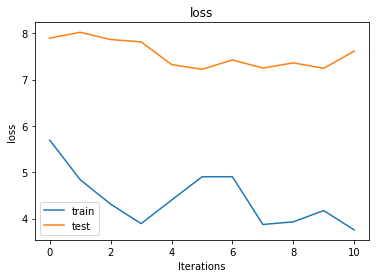

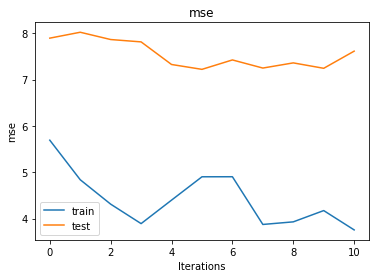

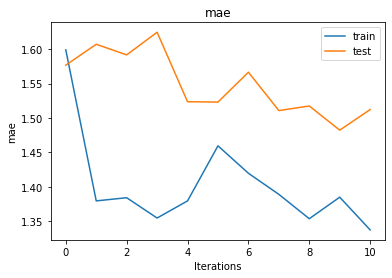

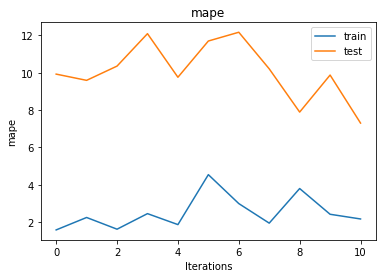

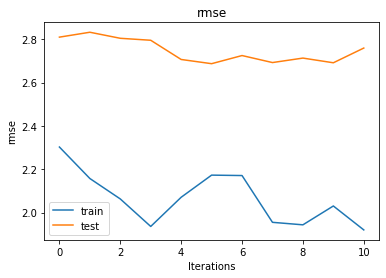

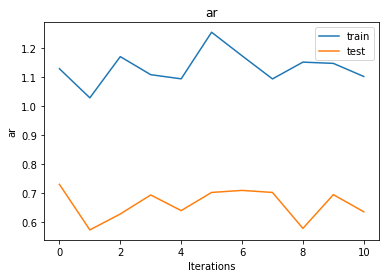

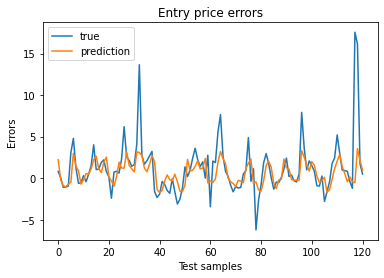

[MSE Baseline] train: 5.039113515385535  test: 9.576144001393745
1/1 [==============================] - 0s 997us/step - loss: 7.6126 - mse: 7.6126 - mae: 1.5123 - mape: 7.3044 - rmse: 2.7591 - ar: 0.6345


In [25]:
data_name = data_names[2]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[2] = ann.evaluate(data_gen_test)

### Facebook Stock

GAN-stock-entry/datasets/FB.csv
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 35)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_10 (LeakyR

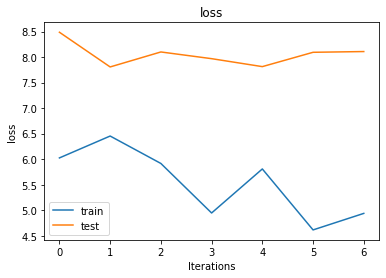

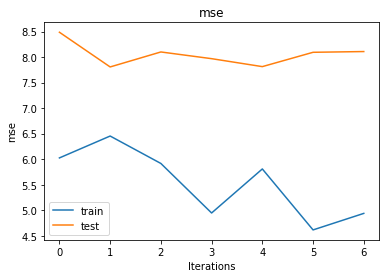

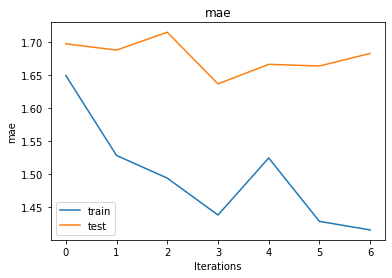

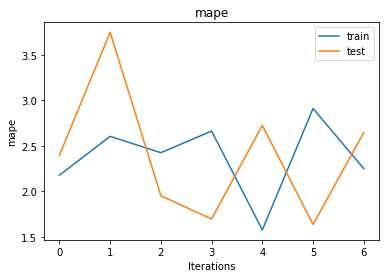

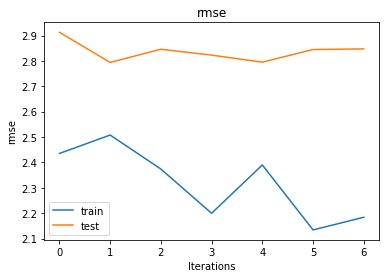

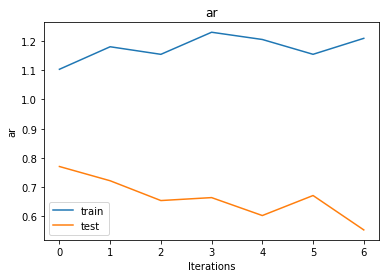

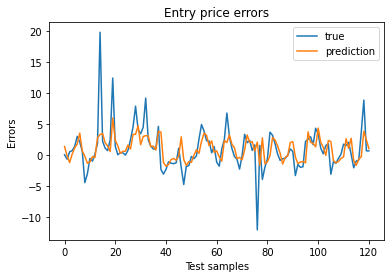

[MSE Baseline] train: 5.222938991411206  test: 9.572238032577555
1/1 [==============================] - 0s 998us/step - loss: 8.1075 - mse: 8.1075 - mae: 1.6831 - mape: 2.6471 - rmse: 2.8474 - ar: 0.5541


In [26]:
data_name = data_names[3]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[3] = ann.evaluate(data_gen_test)

### Tesla Stock

GAN-stock-entry/datasets/TSLA.csv
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 35)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1000)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_13 (Leak

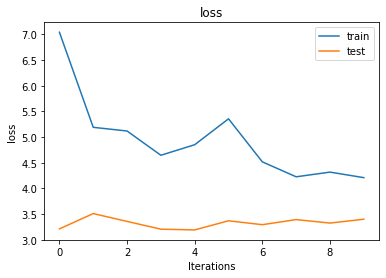

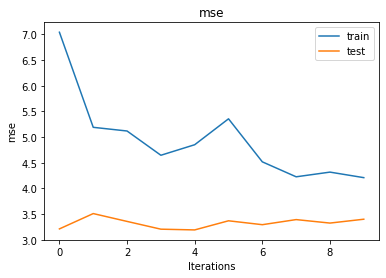

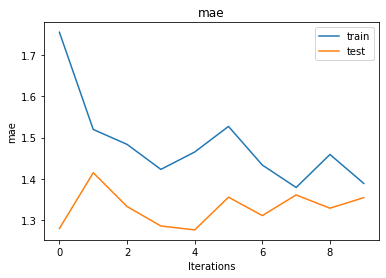

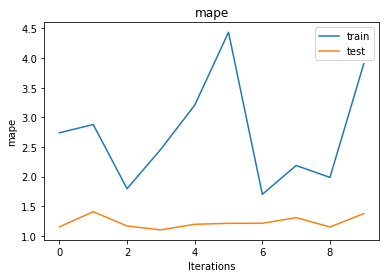

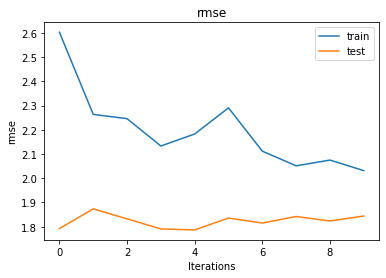

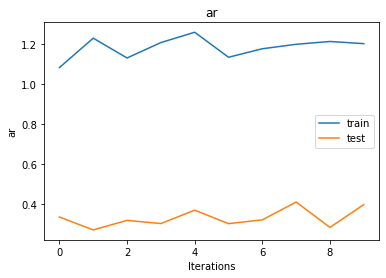

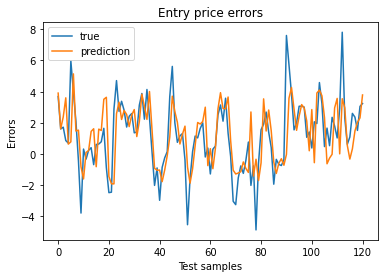

[MSE Baseline] train: 5.209465189166908  test: 4.04776621043118
1/1 [==============================] - 0s 0s/step - loss: 3.4003 - mse: 3.4003 - mae: 1.3552 - mape: 1.3749 - rmse: 1.8440 - ar: 0.3978


In [27]:
data_name = data_names[4]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[4] = ann.evaluate(data_gen_test)

## Results

In [28]:
df = pd.DataFrame(data = results, index = data_names, columns = metrics)
df.loc['mean'] = results.mean(axis=0)
df

,loss,mse,mae,mape,rmse,ar
GOOG,4.346518,4.346518,1.560014,3.456533,2.084830,0.486347
AAPL,6.462795,6.462795,1.635925,1.389356,2.542203,0.389190
AMZN,7.612556,7.612556,1.512317,7.304441,2.759086,0.634519
FB,8.107532,8.107532,1.683092,2.647147,2.847373,0.554126
TSLA,3.400306,3.400306,1.355190,1.374935,1.843992,0.397834
mean,5.985941,5.985941,1.549308,3.234482,2.415497,0.492403
